# Dedup Overheads Observation

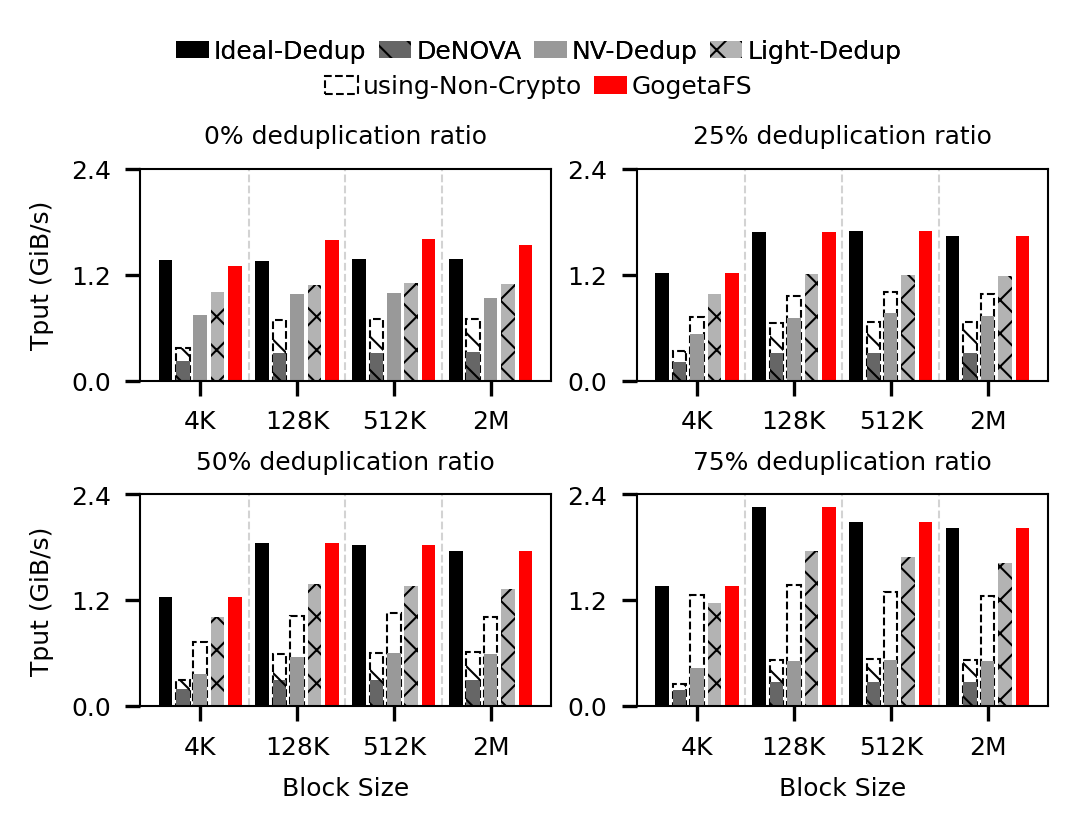

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table-fio", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings
line_width = 0.5
# colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
marks = [">", "x", "o", "s", "D", "+", "v", "<", "d", "^", "p", "h", "H", "X", "*", "|", "_"]
# seven line types
line_types = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
# subtitles = ["(a) SW", "(b) RW", "(c) SR", "(d) RR", "(e) Strict-SW", "(f) Strict-RW"]
fss = ["Light-Dedup-J-Log", "DeNOVA", "NV-Dedup", "Light-Dedup-Improve", "Light-Dedup-J-64bits"]

jobs = [1]
dup_ratios = [0, 25, 50, 75]
blks=["4K", "128K", "512K", "2M"]
blks_pts=[1, 2, 3, 4]

axes = []
lines = []
virt_bar = ""
cmap = "tab10"

ylims = [
    [0, 2.4],
    [0, 2.4],
    [0, 2.4],
    [0, 2.4],
]

bar_width = 0.18
true_bar_width = 0.14
patterns = ['///', '\\\\\\', '', 'XXX', '', '---', '+++']

tot = len(fss) * bar_width

fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(6)))

fig.patch.set_facecolor('white')
for job_idx, job in enumerate(jobs):
    for dup_ratio_idx, dup_ratio in enumerate(dup_ratios):
    # subfig = plt.subplot(gs0[op_idx])
        subfig = plt.subplot(2, 2, job_idx + dup_ratio_idx + 1)
        for idx, fs in enumerate(fss):
            points = []
            for pivot in blks_pts:
                point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
                points.append(point)
            
            if (fs == "NV-Dedup" or fs == "DeNOVA"):
                if fs == "NV-Dedup" and dup_ratio == 0:
                    pass
                else:
                    bws = []
                    virt_fs = fs + "-Non-Crypto"
                    for blk in blks:
                        bws.append(df[(df['system'] == virt_fs) & (df['bs'] == blk) & (df['dup_rate'] == dup_ratio)]["BW"].iloc[0] / 1024)
                    virt_bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5, color="white", edgecolor="black", linestyle="--")
            if fs == "Light-Dedup-J-64bits":
                # add vline to each bar
                for point in points[:-1]:
                    plt.axvline(x=point + true_bar_width, color='lightgray', linewidth=0.5, linestyle='--')
                
            bws = []
                
            for blk in blks:
                if fs == "Light-Dedup-J-Log" and dup_ratio == 0:
                    bws.append(df[(df['system'] == "NOVA-Improve") & (df['bs'] == blk) & (df['dup_rate'] == dup_ratio)]["BW"].iloc[0] / 1024)
                else:
                    if fs == "Light-Dedup-J-Log":
                        bws.append((df[(df['system'] == "Light-Dedup-J-64bits") & (df['bs'] == blk) & (df['dup_rate'] == dup_ratio)]["BW"].iloc[0]) / 1024)
                    else:
                        bws.append(df[(df['system'] == fs) & (df['bs'] == blk) & (df['dup_rate'] == dup_ratio)]["BW"].iloc[0] / 1024)
            
            if fs == "Light-Dedup-J-64bits":
                bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5, color="red")
            else:
                bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5)
                
            # bar, = plt.plot(reg_pts, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5)
            
            lines.append(bar)
            
            
            
            # if idx == 0:
            #     for bw_idx in range(len(bws)):
            #         plt.text(points[bw_idx], bws[bw_idx] + 0.05, "%.2f" % (bws[bw_idx]), ha='center', va='bottom', rotation=90, fontsize=5)
            
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        # if (dup_ratio_idx + job_idx + 1) > 2:
        #     plt.xlabel("Mem (MB)", fontsize=6)
        # else:
        plt.xticks(blks_pts, labels=blks, fontsize=6)
        # plt.xticks(blks_pts, labels=[], fontsize=6)
        subfig.set_title(f"{dup_ratio}% deduplication ratio", fontsize=6)
            
        # axes.append(ax)

        if ((dup_ratio_idx + job_idx + 1) in [1, 3]):
            plt.ylabel('Tput (GiB/s)', fontsize=6)
        if ((dup_ratio_idx + job_idx + 1) in [3, 4]):
            plt.xlabel('Block Size', fontsize=6)
        
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        plt.ylim(ylims[dup_ratio_idx])
        yticks = np.linspace(ylims[dup_ratio_idx + job_idx][0], ylims[dup_ratio_idx + job_idx][1], 3)
        if (ylims[dup_ratio_idx][0] != 0):
            ax.get_yticklabels()[0].set_color("red")
        plt.yticks(yticks, fontsize=6)

_fss = pd.Series(fss)
_fss.replace("Light-Dedup-Improve", "Light-Dedup", inplace=True)
_fss.replace("NOVA-Improve", "NOVA", inplace=True)
_fss.replace("Light-Dedup-J-Log", "Ideal-Dedup", inplace=True)
_fss.replace("Light-Dedup-J-64bits", "GogetaFS", inplace=True)
# _fss.replace("Light-Dedup-J-Log-Regulate", "FDM-Log", inplace=True)
# _fss.replace("Light-Dedup-J-PM-Table", "FDM-Hybrid", inplace=True)
# _fss.replace("Light-Dedup-J-PM-Table-P", "Light-Dedup", inplace=True)
    
# "Light-Dedup-J-Regulate", "Light-Dedup-J-Log-Regulate", "Light-Dedup-J-PM-Table", "Light-Dedup-J-PM-Table-P"

# handles, labels = ax.get_legend_handles_labels()

pos = len(_fss) - 1
_fss = list(_fss)

_fss.insert(pos, "using-Non-Crypto")
lines.insert(pos, virt_bar)

first_legend = fig.legend(lines[:4], _fss[:4], loc='center', bbox_to_anchor=(0.5, 1.08), ncol=4, fontsize=6, frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1.3)

fig.add_artist(first_legend)

fig.legend(lines[4:], _fss[4:], loc='center', bbox_to_anchor=(0.5, 1.03), ncol=4, fontsize=6, frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1.3)

# draw another legend for the hatch


plt.tight_layout(pad=0.4)
# adjust_explanation(fig, axes, context, [1, 1, 1, 1, 0, 0])
# gs0.tight_layout(fig)

plt.savefig("./FIG-MOTIVATION-BW.pdf", bbox_inches='tight', pad_inches=0)


# Breakdown

[['fp_time', 'cmp_time', 'index_time'], ['table_time'], ['io_time'], ['fs_time'], ['other_time']]
Light-Dedup-Improve 50
NV-Dedup-Non-Crypto 50
NV-Dedup 50
DeNOVA 50
[0.7, 0.9, 1.1, 1.3]
['Light-Dedup', 'NV-Dedup-NC', 'NV-Dedup', 'DeNOVA']
[0.7, 0.9, 1.1, 1.3]
(0.6149999999999999, 1.385)
[['fp_time', 'cmp_time', 'index_time'], ['table_time'], ['io_time'], ['fs_time'], ['other_time']]
Light-Dedup-Improve 50
NV-Dedup-Non-Crypto 50
NV-Dedup 50
DeNOVA 50
[0.7, 0.9, 1.1, 1.3]
['Light-Dedup', 'NV-Dedup-NC', 'NV-Dedup', 'DeNOVA']
[0.7, 0.9, 1.1, 1.3]
(0.6149999999999999, 1.385)
[['fp_time', 'cmp_time', 'index_time'], ['table_time'], ['io_time'], ['fs_time'], ['other_time']]
Light-Dedup-Improve 50
NV-Dedup-Non-Crypto 50
NV-Dedup 50
DeNOVA 50
[0.7, 0.9, 1.1, 1.3]
['Light-Dedup', 'NV-Dedup-NC', 'NV-Dedup', 'DeNOVA']
[0.7, 0.9, 1.1, 1.3]
(0.6149999999999999, 1.385)
[['fp_time', 'cmp_time', 'index_time'], ['table_time'], ['io_time'], ['fs_time'], ['other_time']]
Light-Dedup-Improve 50
NV-Dedup-Non

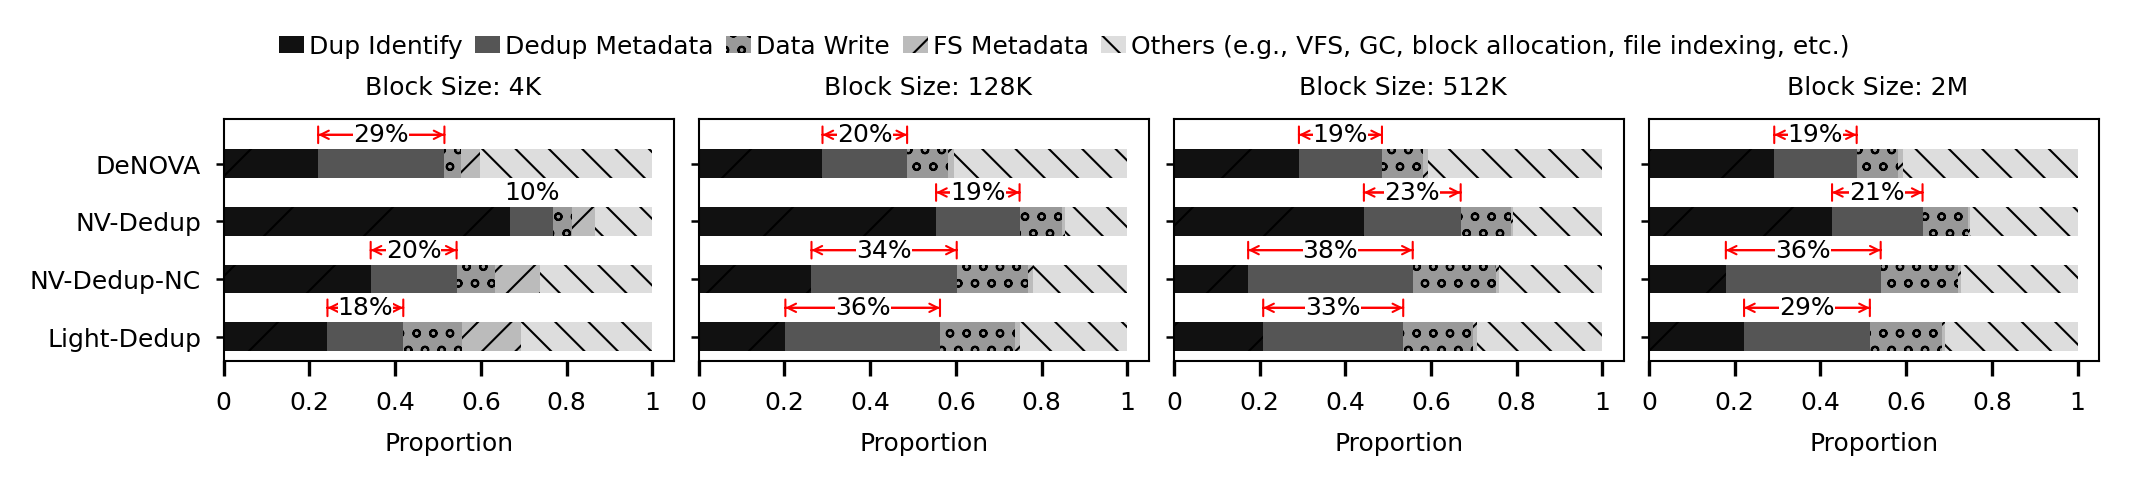

In [11]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table-fio-break", "r") as f:
    df_fio = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

sort_dict = {
    "NOVA-Improve": 3,
    "DeNOVA": 2,
    "NV-Dedup": 1,
    "Light-Dedup-Improve": 0,
}

sort_df = pd.DataFrame(df_fio['system'].map(sort_dict))
# sort_df["num_job"] = df_fio['num_job']
df_fio = df_fio.iloc[sort_df.sort_values(by = ["system"]).index]

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(3.5)))
fig.patch.set_facecolor('white')

bar_width = 0.2
true_width = 0.1
num_job = 1

patterns = ['/', '', 'ooo', "///", "\\\\\\", "xxx"]



breakdown_times = [["fp_time", "cmp_time", "index_time"], ["table_time"], ["io_time"], ["fs_time"], ["other_time"]]

# dup_ratios = [1, 32, 128, 512]
# blks_fio = ['4K', '128K', '512K', '2M']
dup_ratios = [1, 32, 128, 512]
blks_fio = ['4K', '128K', '512K', '2M']
# dup_ratios = [1]
# blks_fio = ['4K']

bars = []
global_color_idx = 0
color_map = {}
# grayscale from dark to light
colors = ["#111111", "#555555", "#999999", "#BBBBBB", "#DDDDDD", "#FFFFFF"]

def annotation_line( ax, xmin, xmax, y, text, ytext=0, linecolor='black', linewidth=1, fontsize=12, foreground='white' ):

    ax.annotate('', xy=(xmin, y), xytext=(xmax, y), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '|-|', 'color':linecolor, 'linewidth':linewidth, 'shrinkA':0, 'shrinkB':0, 'mutation_scale':2})
    ax.annotate('', xy=(xmin, y), xytext=(xmax, y), xycoords='data', textcoords='data',
            arrowprops={'arrowstyle': '<->', 'color':linecolor, 'linewidth':linewidth, 'shrinkA':0, 'shrinkB':0, 'mutation_scale':5})

    xcenter = xmin + (xmax-xmin)/2
    if ytext==0:
        ytext = y + ( ax.get_ylim()[1] - ax.get_ylim()[0] ) / 20

    ax.annotate( text, xy=(xcenter,ytext), ha='center', va='center', fontsize=fontsize, backgroundcolor=foreground, bbox=dict(boxstyle='square,pad=0', fc='white', ec='none'))

for df_idx, df in enumerate([df_fio]):
    for dup_ratio_idx, dup_ratio in enumerate(dup_ratios):
        if df is df_fio:
            real_bs = blks_fio[dup_ratio_idx]
            workload_map = {
                0: [],
                25: [],
                50: [],
                75: [],
            }
            workload_kw = "dup_rate"
            # workloads = [ 0, 25, 50, 75 ]
            # workloads_rename = ["00%", "25%", "50%", "75%"]
            workloads = [ 50 ]
            workloads_rename = ["50%"]
            
        # fss = df['system'].drop_duplicates().reset_index().drop(columns=['index'])['system']
        # , "NOVA-Improve"
        fss = pd.Series(["Light-Dedup-Improve", "NV-Dedup-Non-Crypto", "NV-Dedup", "DeNOVA"])
        print(breakdown_times)
        
        x = list(range(1, len(workloads) + 1))
        
        fid = df_idx * len(dup_ratios) + dup_ratio_idx
        subfig = plt.subplot(1, 4, fid + 1) 
        # ax2 = subfig.twinx()
        pivots = []
        for fs_idx, fs in enumerate(fss):
            for workload_id, workload in enumerate(workloads):
                total_time = 0
                for idx, time in enumerate(breakdown_times):
                    width = 0
                    for t in time:
                        width += df[(df[workload_kw] == workload) & (df['system'] == fs) & (df['bs'] == real_bs)][t].iloc[0] / 1000000000
                    total_time += width
                workload_map[workload].append(total_time)
        bws = []
        for fs_idx, fs in enumerate(fss):
            for workload_id, workload in enumerate(workloads):
                print(fs, workload)
                color_idx = 0
                left = 0
                
                pivot = x[workload_id] - len(fss) * bar_width / 2 + bar_width / 2 + fs_idx * bar_width 
                pivots.append(pivot)
                
                inner_left = 0
                inner_left_range = []
                start = False
                times = []
                
                bw = df[(df[workload_kw] == workload) & (df['system'] == fs) & (df['bs'] == real_bs)]["BW"].iloc[0]
                bws.append(bw)
                for idx, time in enumerate(breakdown_times):
                    width = 0
                    for t in time:
                        width += df[(df[workload_kw] == workload) & (df['system'] == fs) & (df['bs'] == real_bs)][t].iloc[0] / 1000000000 
                    width = 0 if width < 0 else width
                    times.append(width)
                times = [ time / sum(times) for time in times]
                
                for idx, time in enumerate(breakdown_times):
                    width = times[idx]
                    bar, = subfig.barh(y=pivot, width=width, left=left, height=true_width, color=colors[color_idx], hatch=patterns[idx],linewidth=0.5, label=time)
                    if idx == 1 and width != 0:
                        ratio = round(width * 100 / sum(times))
                        annotation_line(ax=subfig, text=f"{ratio}%", xmin=left, xmax=left + width, y=pivot+0.1, ytext=pivot+0.1, linewidth=0.5, linecolor='red', fontsize=6)
                    left = left + width 
                    # if idx == len(breakdown_times) - 1:
                    #     # 32 * 1024 / bw
                    #     subfig.text(left + 0.02, pivot, f"{sum(times)}s", ha='left', va='center', fontsize=6)

                    # dedup metadata
                    if fid == 0:
                        if workload_id == 0:
                            bars.append(bar)
                    else:
                        if workload_id == 0:
                            if idx not in [0, 1, 3, 4]:
                                bars.append(bar)
                    color_idx += 1
        
        subfig.set_xlim([0, 1.05])
        subfig.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        subfig.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=6)
        
        # if fid == 0:
        #     subfig.set_xticks([0, 8, 16, 24, 32, 40])
        #     subfig.set_xticklabels([0, 8, 16, 24, 32, 40], fontsize=6)
        #     subfig.set_xlim([0, 43])
        # else:
        #     subfig.set_xticks([0, 5, 10, 15, 20, 25])
        #     subfig.set_xticklabels([0, 5, 10, 15, 20, 25], fontsize=6)
            
        # title_prefix = "(a)" if fid == 0 else "(b)"
        title_prefix = ""
        subfig.set_title(f"{title_prefix} Block Size: {real_bs}", fontsize=6)
        # if blk_idx >= 1:
        subfig.set_xlabel("Proportion", fontsize=6)
        # else:
        #     subfig.set_xticklabels([], fontsize=6)
            
        subfig.set_yticks(x, minor=False)
        # if fid % 2 == 0:
        subfig.set_yticklabels([], fontsize=6, minor=False)
        fss = fss.map({
            "NOVA-Improve": "Ideal-Dedup",
            "Light-Dedup-Improve": "Light-Dedup",
            "Light-Dedup-J-64bits": "GogetaFS",
            "DeNOVA": "DeNOVA",
            "NV-Dedup": "NV-Dedup",
            "NV-Dedup-Non-Crypto": "NV-Dedup-NC",
        })
        yticklabels = list(fss)
        yticklabels = yticklabels * len(workloads)
        pivots.sort()
        pivots = [ round(pivot, 1) for pivot in pivots]
        pivots = [ pivot - 0.01 if pivot in x else pivot for pivot in pivots]
        print(pivots)
        subfig.set_yticks(pivots, minor=True)
        if dup_ratio_idx == 0:
            subfig.set_yticklabels(yticklabels, minor=True, fontsize=6)
        print(yticklabels)
        # subfig.get_yaxis().set_tick_params(which='major', pad=17)
        print(pivots)
        # else:
        #     subfig.set_yticklabels([], fontsize=6)
        # subfig.set_ylim([0.1, len(pivots) + 0.1])
        print(subfig.get_ylim())
        ylim = subfig.get_ylim()
        subfig.set_ylim([ylim[0], ylim[1] + 0.07])
        # ax2 = subfig.twinx()
        # ax2.set_yticks(pivots, minor=True)
        # ax2.set_yticklabels([round(32 * 1024 / bw) for bw in bws], minor=True, fontsize=6)
        # ax2.set_ylim(ylim)
        # ax2.set_yticklabels([])
        # if dup_ratio_idx == 3:
        # ax2.set_ylabel("Time (s)", fontsize=6)
        
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
            
        subfig.tick_params(bottom=True, top=False, left=True, right=False, which='minor')
        subfig.tick_params(bottom=True, top=False, left=False, right=False, which='major')
        # ax2.tick_params(bottom=True, top=False, left=False, right=False, which='major')
    
print(len(bars))

legends = ["Dup Identify", "Dedup Metadata", "Data Write", "FS Metadata", "Others (e.g., VFS, GC, block allocation, file indexing, etc.)" ]
fig.legend(handles=bars, labels=legends, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.1), frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=6)

plt.tight_layout(pad=0.4)
plt.savefig("./FIG-MOTIVATION.pdf", bbox_inches='tight', pad_inches=0)
